# Useful tricks vol. 4 - Decision trees, RFs, GBMs and certainty about predictions

## Decision trees

### Advantages
- generaly good baseline, reasonably fast
- easy to visualize, can be intuitively interpreted

### Disadvantages
- easy to overfit
    - pre-prunning (limiting tree's growth), post-prunning (removing nodes with little information after the full tree has been grown)
- 'learns by heart' - Decision tree is not able to generate new prediction (in the same way e.g. Linear Regression is), it'll just keep predicting the last known point in the training dataset

#### When to use
- **Decision trees:** Very fast, don’t need scaling of the data, can be visualized and easily explained.

- **Random forests:** Nearly always perform better than a single decision tree, very robust and powerful. Don’t need scaling of data. Not good for very high-dimensional sparse data.

- **GBMs:** Often slightly more accurate than random forests. Slower to train but faster to predict than random forests, and smaller in memory. Need more parameter tuning than random forests.

In [1]:
import numpy as np
import mglearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [2]:
cancer_dataset = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer_dataset.data,cancer_dataset.target)
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print(tree.score(X_train, y_train))
print(tree.score(X_test, y_test))

1.0
0.916083916083916


### Random forests
- visualize the output of individual forests using the moon dataset

#### Parameters
- `n_jobs` - set to `-1` to use all cores
- `random_state` influences how the model is built - e.g. when comparing 2 models it's important to fix this parameter
- `n_estimators` - number of trees
- `max_features` - how random each tree is, small reduces overfitting. `sqrt(n_features)` for classification and `log2(n_features)` for regression work best
    - improves performance, can help reduce computation time
- `max_depth` - controls pre-prunning

(100, 2)


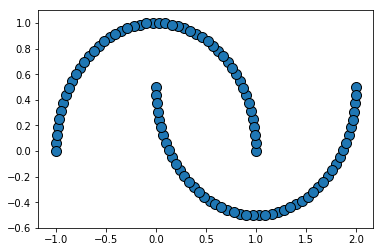

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
X,y = make_moons()
print(X.shape)
mglearn.discrete_scatter(X[:,0],X[:,1])

Visualize how the forest averages decision boundaries of multiple tree by accessing its `.estimators_` attribute

Text(0.5, 0, 'Feature')

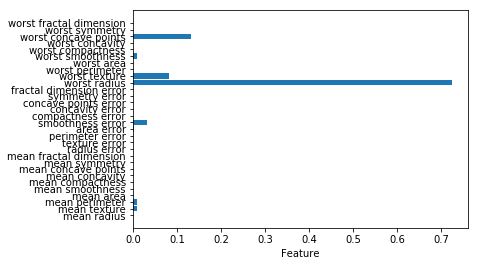

In [4]:
# check out feature importances
n_features = len(cancer_dataset.feature_names)
plt.barh(range(n_features), tree.feature_importances_)
plt.yticks(np.arange(n_features), cancer_dataset.feature_names)
plt.xlabel("Feature importance")
plt.xlabel("Feature")

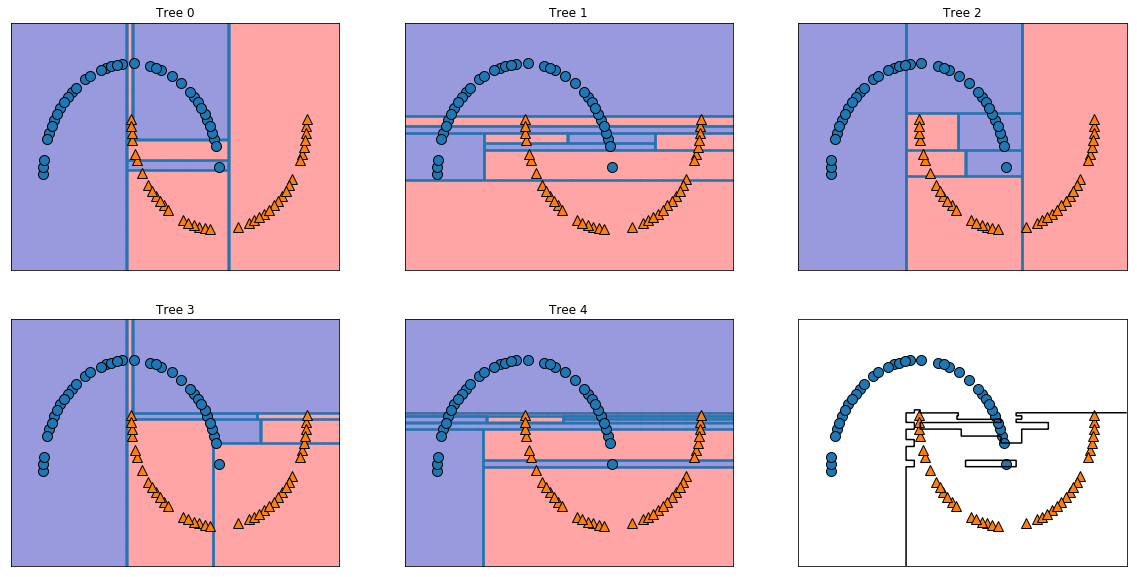

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
forest = RandomForestClassifier(n_estimators=5)
forest.fit(X_train, y_train)
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title(f"Tree {i}")
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
mglearn.plots.plot_2d_separator(forest, X_train, ax=axes[-1, -1])
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(cancer_dataset.data,cancer_dataset.target)
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

1.0
0.951048951048951


Text(0.5, 0, 'Feature')

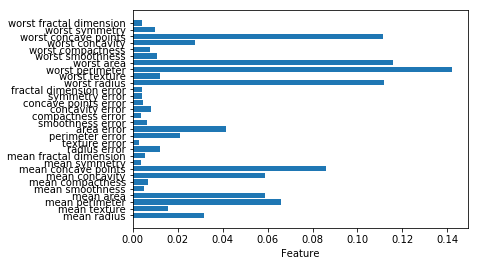

In [7]:
# check out feature importances of a random forest - more features are considered important
n_features = len(cancer_dataset.feature_names)
plt.barh(range(n_features), forest.feature_importances_)
plt.yticks(np.arange(n_features), cancer_dataset.feature_names)
plt.xlabel("Feature importance")
plt.xlabel("Feature")

### Gradient boosting machines
- no randomization
- builds trees **serially**, each tree correcting missclassifications of the previous one
- strong pre-prunning is used
- often very shallow trees are 

#### Advantages
- one of the more powerful

#### Disadvantages
- slower
- might not work well on high-dimentional sparse data

#### Parameters
- apart from pre-prunning (`max_depth`) and number of trees (`n_estimators`), `learning_rate` should be considered: how strongly should each tree try to correct mistakes of its predecessor

#### Tips
- kmight be of use to check out the `xgboost` package - faster than sklearn's implementation

#### Let's try to use it with the Breast cancer dataset

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier() # max_depth=3, lr=0.1
gbc.fit(X_train, y_train)
print(gbc.score(X_train, y_train))
print(gbc.score(X_test, y_test))

1.0
0.958041958041958


We're likely overfitting, let's play around with the hyperparameters

In [9]:
gbc = GradientBoostingClassifier(max_depth=1)
gbc.fit(X_train, y_train)
print(gbc.score(X_train, y_train))
print(gbc.score(X_test, y_test))

0.9929577464788732
0.958041958041958


In [10]:
gbc = GradientBoostingClassifier(learning_rate=0.01)
gbc.fit(X_train, y_train)
print(gbc.score(X_train, y_train))
print(gbc.score(X_test, y_test))

0.9812206572769953
0.8601398601398601


Text(0.5, 0, 'Feature')

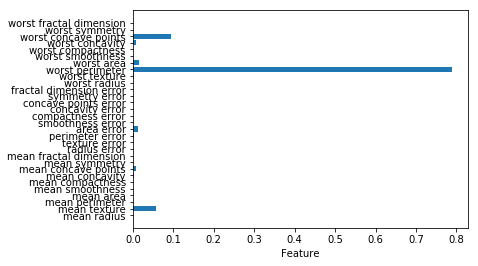

In [11]:
# check out feature importances of a gbc
n_features = len(cancer_dataset.feature_names)
plt.barh(range(n_features), gbc.feature_importances_)
plt.yticks(np.arange(n_features), cancer_dataset.feature_names)
plt.xlabel("Feature importance")
plt.xlabel("Feature")

### Expressing trust in the predictions
Some classifiers have `.decision_function()` that tells us how strongly the model believes that a specific datapoint belongs to the positive/negative class (repr. by positive/negative values)

Similarly, `.predict_proba()` shows the estimated probability that a specific datapoint belongs to class 1 vs. class 2

Generally, a model with lower complexity has much more uncertainty about the predictions.

In [17]:
print(gbc.decision_function(X_test)[:6])
print(gbc.predict_proba(X_test)[:6, :])
# prob of first class (first column) vs. second class (second column)

[-1.2261079   1.66773348 -1.2261079   1.63194094  1.74350175  1.74350175]
[[0.77313664 0.22686336]
 [0.1587266  0.8412734 ]
 [0.77313664 0.22686336]
 [0.16356465 0.83643535]
 [0.14886869 0.85113131]
 [0.14886869 0.85113131]]


In [23]:
from sklearn.datasets import load_iris
iris_dataset = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_dataset.data,iris_dataset.target)
gbc.fit(X_train, y_train)
print(gbc.decision_function(X_test).shape)
print(gbc.decision_function(X_test)[:6])
print(gbc.predict_proba(X_test).shape)
print(gbc.predict_proba(X_test)[:6])
print(np.argmax(gbc.predict_proba(X_test), axis=1)[:6])

(38, 3)
[[-0.49757989 -0.51174477  1.51120201]
 [-0.49757989 -0.51174477  1.51120201]
 [-0.49912208 -0.51174477  1.51120201]
 [ 1.52626729 -0.50893001 -0.51800817]
 [-0.49757989 -0.51174477  1.51120201]
 [ 1.52626729 -0.50893001 -0.51800817]]
(38, 3)
[[0.10593033 0.10444042 0.78962925]
 [0.10593033 0.10444042 0.78962925]
 [0.10578436 0.10445747 0.78975817]
 [0.79356976 0.10368362 0.10274662]
 [0.10593033 0.10444042 0.78962925]
 [0.79356976 0.10368362 0.10274662]]
[2 2 2 0 2 0]
